# Advanced Techniques and The Functional API

In this lecture, we will cover some advanced neural network techniques, focusing in on our convolution neural networks.

In [107]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

from tensorflow.keras import layers

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from PIL import Image

import os
import re

## Keras Sequantial API vs. Functional API

Up until now we have focused on the sequential API.
This is a good chioce for when we have a network which is composed of a sequence of layers, one after the other.
However, we sometimes want to construct more complicated networks, either with multiple inputs, multiple outputs, or just a non-sequential internal structure.
In this instance, we need to instead rely on the functional API.

[Keras Functional API Documentation](https://keras.io/guides/functional_api/)

Let's build a simple neural network, first using the sequential API, then again with the functional API.

In [2]:
X, y = wine_data = load_wine(as_frame=True, return_X_y=True)

X = StandardScaler().fit_transform(X)

input_size = X.shape[1]

We are only using the dataset to show how the different APIs work, so we will not worry about train/test split for now

In [3]:
# Using the sequential model

sequential_model = Sequential()

sequential_model.add(layers.Input((input_size, )))
sequential_model.add(layers.Dense(100, activation='relu'))
sequential_model.add(layers.Dense(1, activation='linear'))

sequential_model.compile(loss='mse', optimizer='adam')

sequential_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         1,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,501 (5.86 KB)

 Trainable params: 1,501 (5.86 KB)

 Non-trainable params: 0 (0.00 B)

Layers in Keras are Python _callables_, meaning that we can treat them as if they are funcitons.
Using them in this way allows us to instead create our neural networks in a different way.
Let's create the same network as above, but with the functional API.

In [9]:
functional_input = layers.Input((input_size, ))
functional_hidden = layers.Dense(100, activation='relu')(functional_input)
functional_output = layers.Dense(1, activation='linear')(functional_hidden)

# Create the model using multiple inputs and oputputs
functional_model = Model(inputs=functional_input, outputs=functional_output)

functional_model.compile(loss='mse', optimizer='adam')

functional_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │         1,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,501 (5.86 KB)

 Trainable params: 1,501 (5.86 KB)

 Non-trainable params: 0 (0.00 B)

The two models we created can now be trained in the normal way:

In [10]:
# train and evaluate the sequential model

sequential_model.fit(X, y, epochs=50, verbose=0)
y_hat = sequential_model.predict(X)

print("Sequential R^2: ", r2_score(y, y_hat))
print('----')

# train and evaluate the functional model

functional_model.fit(X, y, epochs=50, verbose=0)
y_hat = functional_model.predict(X)

print("Functional R^2: ", r2_score(y, y_hat))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Sequential R^2:  0.9932600855827332
----
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Functional R^2:  0.9675450325012207


We can see that the results are very similar, which should not be a surprise.

## Multi-input models using Concatenate Layers

The real power of using the functional API comes from being able to define more complicated model archetectures that the `Sequential` model cannot create.
A core element of this functionality are the merging layers which allow you to merge two input layers into a single output layer.
The simplist of these is the [Concatenate Layer](https://keras.io/api/layers/merging_layers/concatenate/).

In [11]:
# Example using the concatenate layer

# Make sure these are rank 2 tensors (i.e. matrices)
input_1 = np.array([[1, 2, 3]])
input_2 = np.array([[10, 20, 30]])

axis_1_concat = layers.Concatenate()([input_1, input_2]).numpy()
axis_0_concat = layers.Concatenate(axis=0)([input_1, input_2]).numpy()

print('Axis 1 (Default):')
print(axis_1_concat)
print('\nAxis 0:')
print(axis_0_concat)

Axis 1 (Default):
[[ 1  2  3 10 20 30]]

Axis 0:
[[ 1  2  3]
 [10 20 30]]


Using the concat layer allows us to combine two input sources into a single model.
Let's build a full model which uses this paradigm.

## Housing Value Dataset

We will explore a [housing value data set](https://github.com/emanhamed/Houses-dataset?tab=readme-ov-file), which combines some features about homes with images of those homes.

> *Dataset Citation*
>
>H. Ahmed E. and Moustafa M. (2016). House Price Estimation from Visual and Textual Features.In Proceedings of the 8th International Joint Conference on Computational Intelligence (IJCCI 2016)ISBN 978-989-758-201-1, pages 62-68. DOI: 10.5220/0006040700620068

In [12]:
house_data = pd.read_csv(
    "../data/Houses-dataset-master/Houses Dataset/HousesInfo.txt",
    names=['n_bedrooms', 'n_bathrooms', 'area', 'zipcode', 'price'],
    delimiter=' ',
)

house_data.head()

,n_bedrooms,n_bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


For now, we will throw out the zipcode information since it is too sparsely populated to be useful.

In [25]:
X = house_data[['n_bedrooms', 'n_bathrooms', 'area']].values
y = house_data['price'].values

# Scale the input features

X = StandardScaler().fit_transform(X)

### Image Features Pipeline

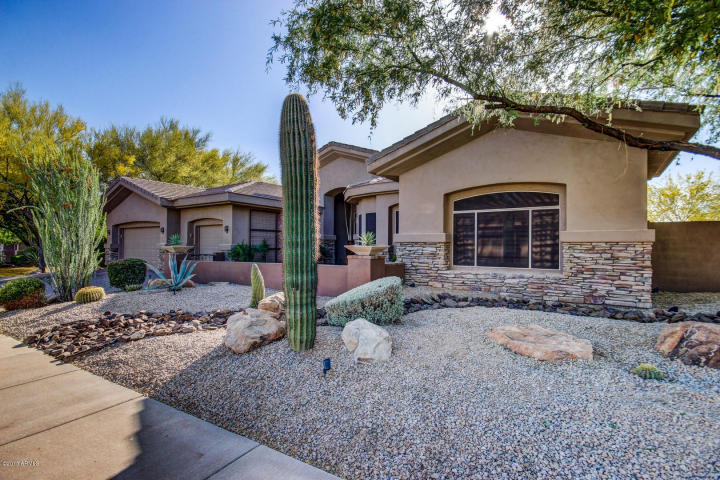

In [123]:
example_image = Image.open("../data/Houses-dataset-master/Houses Dataset/1_frontal.jpg")
example_image

In this dataset, not all images are the same size, so we will need to include some preprocessing in our neural network.

In [88]:
# Create a helper function for building the image network sections
# The function will return both the input and output layers of the image pipeline

def build_image_pipeline(n_conv_layers=2):
    inputs = layers.Input(shape=(64, 64, 3))
    x  = inputs
    
    for _ in range(n_conv_layers):
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)

    return inputs, x

### Combinging all inputs with `Concatenate`

We will now combing all our image pipelines using a concatenation layer.
Notice that when we build the pre-processing pipelines, we created a `keras.Model` object.
These objects are also callables, so we can combine them into larger models.

Here we define a function to build the model, and then use the `plot_model` utility function to display it.

> Note: You need `graphviz` installed on your system for `plot_model` to work properly.

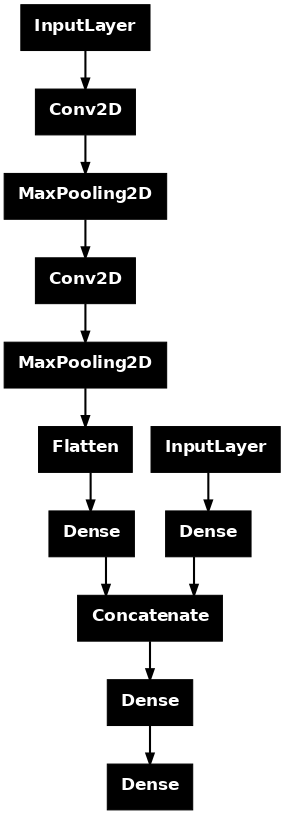

In [326]:
def build_full_model():
    inputs = []
    outputs = []

    # Create the image pipelines
    inp, out = build_image_pipeline()
    inputs.append(inp)
    outputs.append(out)

    # Add the numerical features (Number of bedrooms, bathrooms, sqr footage)
    numerical_inputs = layers.Input((3, ))
    numerical_hidden = layers.Dense(8)(numerical_inputs)
    
    inputs.append(numerical_inputs)
    outputs.append(numerical_hidden)

    concatenated = layers.Concatenate()(outputs)  # Combine image and numerical features
    hidden_dense = layers.Dense(64, activation='relu')(concatenated)
    final_dense = layers.Dense(1, activation='linear')(hidden_dense)

    model = Model(inputs=inputs, outputs=final_dense)

    model.compile(loss='mse', optimizer='adam')
    
    return model

model = build_full_model()

plot_model(model, dpi=75)

Let's test out the network on some basic input data to make sure it works as we intend.

### Creating the Training Dataset

Crafting the correct input training dataset for these types of models can get a little confusing!
Every dataset is organized differently, but we will go through the process for the housing data.

This dataset provided is organized with this structure:

```
Houses Dataset
├── 1_frontal.jpg
├── 1_kitchen.jpg
├── 1_bathroom.jpg
├── 1_bedroom.jpg
├── 2_frontal.jpg
├── 2_kitchen.jpg
├── 2_bathroom.jpg
├── 2_bedroom.jpg
├── ...
└── HousesInfo.txt
```
We already loaded the `HousesInfo.txt` file which contains the numerical features and the target.

Each image file looks like `ImageNumber_RoomType.jpg`.
Our dataframe which contains the features started indexing at 0, so we will need to correct for that when we load the images.

Our model will only use the "frontal" images for now.

In [91]:
def load_images(directory, room_name):

    image_dict = {}
    
    for file_name in os.listdir(directory):
        if file_name.endswith(".jpg"):
            sample_id, image_type = file_name.split('_')

            # Subtract 1 since the provided dataset starts counting at 1
            sample_id = int(sample_id) - 1
            
            if image_type.startswith(room_name):
                file_path = os.path.join(directory, file_name)
                loaded_image = tf.io.read_file(file_path)
                image = tf.image.decode_jpeg(loaded_image, channels=3)

                # Preprocess the images
                # Make sure this matches the expected input dimensions of our model!
                image = tf.image.resize(image, (64, 64))
                image = image / 255.0
                
                image_dict[sample_id] = image

            # Sort the images
            image_list = [i for _, i in sorted(image_dict.items())]

    return tf.stack(image_list)
    
frontal_images = load_images('../data/Houses-dataset-master/Houses Dataset/', 'frontal')

Tensorflow uses its own array type `tf.Tensor`.
We can either input these into models, or numpy arrays, but you cannot mix them.
Since our `load_images` function returns tensors, we will make the `X` and `y` arrays a tensors as well.

In [327]:
X = tf.convert_to_tensor(X)
y = tf.convert_to_tensor(y)

Now we have our training data ready, we can test out that everything is formed properly by calling the model
with a small input.

> Note: Multi-input models requre that the input is a Python tuple containing the inputs!

In [328]:
# This should return a 3x1 vector
model((frontal_images[:3], X[:3])).numpy()

array([[-0.5492663 ],
       [-0.39664942],
       [-0.34687418]], dtype=float32)

We are ready to train!

In [329]:
%%time

history = model.fit((frontal_images, X), y, epochs=1000, verbose=0)

CPU times: user 1min 41s, sys: 12.1 s, total: 1min 53s
Wall time: 1min 21s


<Axes: >

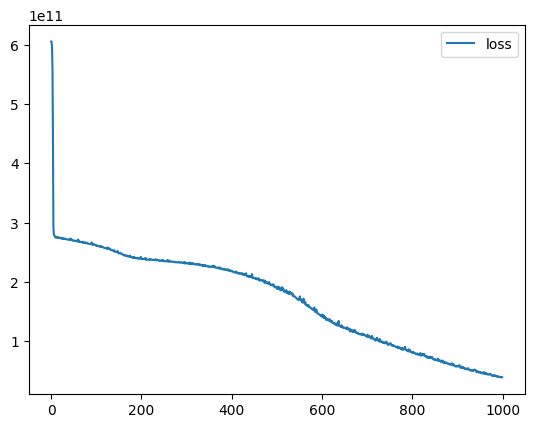

In [330]:
pd.DataFrame(history.history).plot()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Text(0.5, 1.0, 'R^2 = 0.8456409573554993')

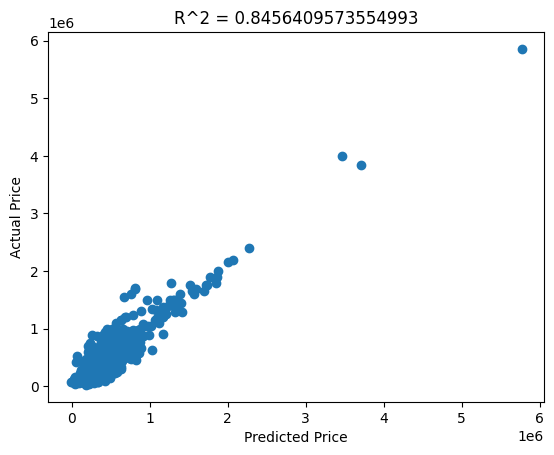

In [331]:
y_hat = model.predict((frontal_images, X))

r2 = r2_score(y.numpy(), y_hat)

fig, ax = plt.subplots()

ax.scatter(y_hat, y.numpy())
ax.set_xlabel('Predicted Price')
ax.set_ylabel('Actual Price')
ax.set_title(f'R^2 = {r2}')

## Object Detection using Multi-Output Models

We can also use the functional API to build more advanced models with multiple outputs.
We will demonstrate this with a playing card object detection model where we need to detect a bounding box for playing cards,
as well as determine what kind of card it is.

> Note: There are many ways to accomplish this task. This is only one example apprach!

### Loading The Data

[Source for the data](https://www.kaggle.com/datasets/luantm/playing-card)

As with the last example, we will need to generate our dataset tensors by loading and preprocessing the data.

Once again, let's take a look at the structure of the data:

```
cards_dataset
├── test
│   ├── cam_image10.jpg
│   ├── cam_image10.xml
│   ├── ...
├── train
│   ├── cam_image10.jpg
│   ├── ...
├── test
├── test_labels.csv
└── train_labels.csv
```
So we have `train` and `test` directories, with image files and XML files.
We also have CSVs with the same information as the XML files at the top level directory.

Taking a look at the CSV:

In [296]:
card_df_train = pd.read_csv("../data/playing_cards/card_dataset/train_labels.csv")
card_df_test = pd.read_csv("../data/playing_cards/card_dataset/test_labels.csv")
card_df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cam_image1.jpg,480,270,queen,173,24,260,137
1,cam_image1.jpg,480,270,queen,165,135,253,251
2,cam_image1.jpg,480,270,ten,255,96,337,208
3,cam_image10.jpg,960,540,ten,501,116,700,353
4,cam_image10.jpg,960,540,queen,261,124,453,370


In [290]:
card_df_train['class'].value_counts()

class
king     95
ace      92
nine     89
jack     89
ten      82
queen    80
Name: count, dtype: int64

So this dataset contains filenames in the CSV.
We will use this, then, to construct our input tensors.

Next, let's look at one of the images:

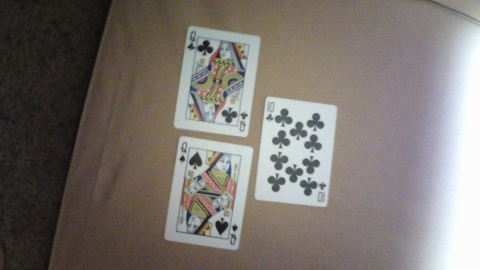

In [165]:
example_image = Image.open("../data/playing_cards/card_dataset/train/cam_image1.jpg")
example_image

This shows us that we have multiple cards per image!
This is a more advanced problem do deal with.
For now, let's just remove those images from our dataset.

We could try to tackle that problem later with a more advanced technique.

In [297]:
# Remove any image with more than one card

def remove_multi_card_images(card_df):
    card_counts = card_df['filename'].value_counts()
    card_counts.name = 'card_count'

    card_df = card_df.merge(card_counts, on='filename')
    card_df = card_df[card_df['card_count'] == 1]
    card_df.drop('card_count', axis=1, inplace=True)
    
    return card_df

card_df_train = remove_multi_card_images(card_df_train)
card_df_test = remove_multi_card_images(card_df_test)

### Processing the Numerical Data

First, let's process the numerical data.
The bounding boxes are with respect to the pixel locations in the image.
However, it is more convienient to use values between 0 and 1.
We will achieve this by dividing the bounding box values by the width or height.

In [298]:
def normalize_bounding_boxes(card_df):
    card_df['xmin'] = card_df['xmin'] / card_df['width']
    card_df['xmax'] = card_df['xmax'] / card_df['width']
    card_df['ymin'] = card_df['ymin'] / card_df['height']
    card_df['ymax'] = card_df['ymax'] / card_df['height']

normalize_bounding_boxes(card_df_train)
normalize_bounding_boxes(card_df_test)

card_df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
5,cam_image11.jpg,960,540,nine,0.234375,0.177778,0.510417,0.733333
6,cam_image12.jpg,960,540,king,0.377083,0.275926,0.583333,0.720370
7,cam_image13.jpg,960,540,jack,0.363542,0.262963,0.572917,0.718519
8,cam_image14.jpg,960,540,jack,0.309375,0.309259,0.533333,0.777778
9,cam_image15.jpg,960,540,ace,0.382292,0.335185,0.613542,0.846296


We now need to create the tensor objects which will contain our targets.

In [361]:
bbox_train = tf.convert_to_tensor(card_df_train[['xmin', 'xmax', 'ymin', 'ymax']])
bbox_test = tf.convert_to_tensor(card_df_test[['xmin', 'xmax', 'ymin', 'ymax']])

card_map = {'nine': 0, 'ten': 1, 'jack': 2, 'queen': 3, 'king': 4, 'ace': 5}

# For use later
inverse_card_map = {v: k for k, v in card_map.items()}

labels_train = tf.convert_to_tensor(card_df_train['class'].map(card_map))
labels_test = tf.convert_to_tensor(card_df_test['class'].map(card_map))

Next we will load the images into tensors.
For this dataset, the image filename is included in the data frame, so we can just use that.

In [317]:
def load_image(directory, file_name):
        
    file_path = os.path.join(directory, file_name)
    loaded_image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(loaded_image, channels=3)

    # Preprocess the images
    # Make sure this matches the expected input dimensions of our model!
    image = tf.image.resize(image, (64, 64))
    image = image / 255.0

    return image

# Load the train and testing images into tensors
train_images = card_df_train['filename'].apply(lambda f: load_image('../data/playing_cards/card_dataset/train', f))
train_images = tf.stack(train_images.values)

test_images = card_df_test['filename'].apply(lambda f: load_image('../data/playing_cards/card_dataset/test', f))
test_images = tf.stack(test_images.values)

### Designing the Neural Network

We are now ready to desing our neural network.
This network needs to output several things:

* The (x, y) coorrdinates for each boudning box
* The predicted card type for each bounding box

In [332]:
def create_card_box_model():
    input_layer = layers.Input((64, 64, 3))

    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(input_layer)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)

    # We make sure to give this layer a name so we can refer to it in the loss function
    bbox_output = layers.Dense(4, activation="sigmoid", name="bounding_boxes")(x)

    num_classes = 6  # 9, 10, J, Q, K, A

    # Also giv this layer a name
    class_output = layers.Dense(num_classes, activation="softmax", name="class_labels")(x)
    
    # Define model
    model = Model(inputs=input_layer, outputs=[bbox_output, class_output])

    # Here we define the correct loss type for each output
    model.compile(optimizer="adam", 
              loss={"bounding_boxes": "mse", "class_labels": "sparse_categorical_crossentropy"},
              metrics={"bounding_boxes": "mae", "class_labels": "accuracy"})

    return model

model = create_card_box_model()

model.predict(train_images[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


[array([[0.5236244 , 0.51777846, 0.5595384 , 0.48261836]], dtype=float32),
 array([[0.15566973, 0.16096658, 0.19103722, 0.19009283, 0.15369669,
         0.14853697]], dtype=float32)]

In [333]:
%%time

history = model.fit(train_images, (bbox_train, labels_train), epochs=20, verbose=0)

CPU times: user 16.4 s, sys: 183 ms, total: 16.5 s
Wall time: 16.1 s


<Axes: >

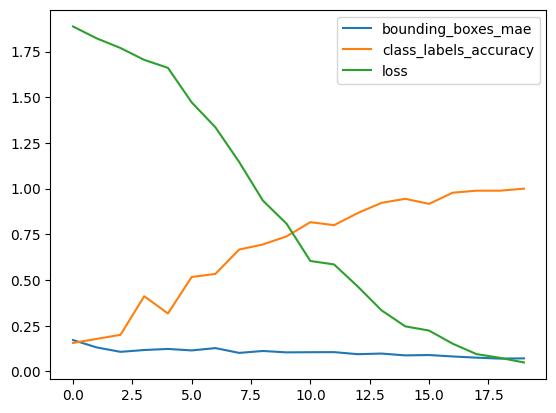

In [334]:
pd.DataFrame(history.history).plot()

In [337]:
test_bounding_boxes, test_label_probas = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [370]:
int(labels_test[0])

5

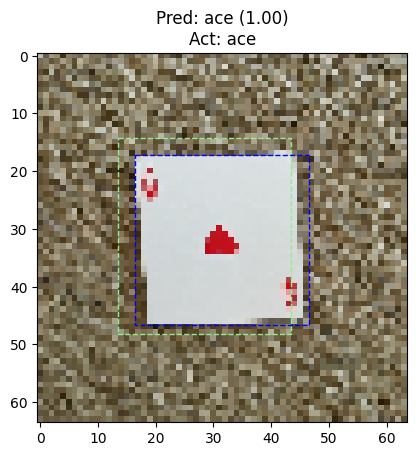

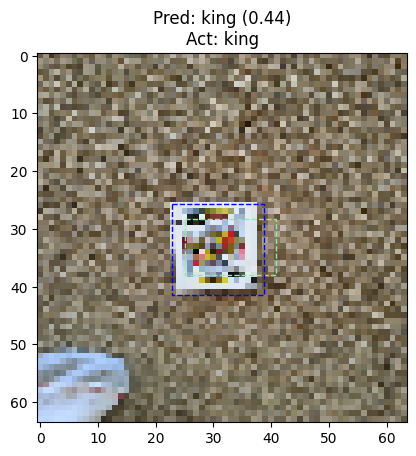

In [391]:
def plot_prediction(idx):
    card_proba = test_label_probas[idx].max()
    card_type = inverse_card_map[test_label_probas[idx].argmax()]
    act_card = inverse_card_map[int(labels_test[idx])]
    
    fig, ax = plt.subplots()
    
    ax.imshow(test_images[idx])

    xmin, xmax, ymin, ymax = test_bounding_boxes[idx] * 64
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax-ymin, facecolor='none', edgecolor='lightgreen', linestyle='--')
    ax.add_patch(rect)

    
    xmin, xmax, ymin, ymax = bbox_test[idx] * 64
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax-ymin, facecolor='none', edgecolor='blue', linestyle='--')
    ax.add_patch(rect)
    
    
    ax.set_title(f"Pred: {card_type} ({card_proba:0.2f})\nAct: {act_card}")


# Change the index here to see different test predictions
plot_prediction(0)
plot_prediction(1)

# Homework

1. In the lecture today, we only included one image input in our housing model. Create a new neural network which uses all four images as inputs. Use `plot_model` to show the model's structure. **You do not need to train the model**
2. Remember in class that we removed any playing card images with more than one card. Can you think of any way we could address this problem? Describe your idea.
3. Using the MNIST dataset from the previous lecture, create a multi-input model which takes as its input two images of digits, and predicts whether or not the images are the same digit. You will have to create a suitable training and testing set based on the MNIST dataset for this task.